# Computational Structural Design II - Geometry, Data and Visualization

### Learning Goal: 
- Understand Mesh Datastructure
- How to Construct a Mesh
- Mehs Vertices, Faces, Edges

### Content:
- [A. Mesh Introduction](#MeshIntro)
- [B. Mesh Vertex, Edge, Face](#MeshB)
- [C. Mesh Normals](#MeshC)
- [D. Exercise: Geodesic Dome](#MeshD)
---


<a id='MeshIntro'></a>
# A. Mesh
## A1. Mesh in Form Finding
Form finding a cable-net or generating a compression-only vault usually starts with a **2D mesh**, which represents the horizontal projection of the eventual structure. The line segments of this mesh is called **Pattern**. The following picture shows you an existing structure and its corresponding pattern. The form-found **Thrust** is also a mesh, but in 3D space. 

![img](https://files.gitbook.com/v0/b/gitbook-legacy-files/o/assets%2F-M730QpQnbAMvz44bqhc%2F-MOff3g181Ib3KNlmKgc%2F-MOfhAWYJRaSfNZucLzL%2Fimage.png?alt=media&token=839252d4-a77e-42cb-81cf-4b6071a5c598)
<center>Nave Vault of the Sherborne Abbey, Dorset, UK (photo by Lawrence Lew)</center>
</br>



## A2. Generate Polygon - Geometry and Topology
Firstly, let's create 4 polygons using `compas.geometry.Polygon` and visualize them in different colors. Make sure that the winding order (point order) of the polygons are either all clockwise or all counter-clockwise. 

<img src="img/week5_1.png" width="500" style="margin-left:auto; margin-right:auto"/>
</br>

### A2_a. Generate Polygon from Points

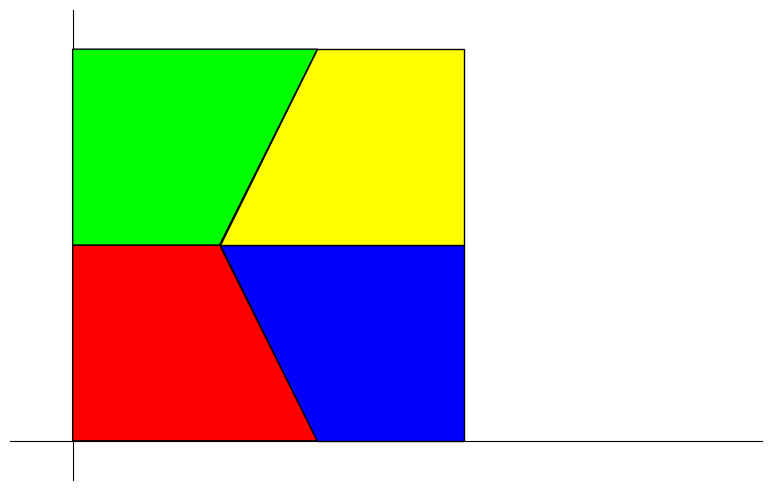

In [1]:
from compas.geometry import Polygon
from compas_plotters import Plotter

polygon_1 = Polygon([[0, 0, 0], [2.5, 0, 0], [1.5, 2, 0], [0, 2, 0]])
polygon_2 = Polygon([[2.5, 0, 0], [4, 0, 0], [4, 2, 0], [1.5, 2, 0]])
polygon_3 = Polygon([[0, 2, 0], [1.5, 2, 0], [2.5, 4, 0], [0, 4, 0]])
polygon_4 = Polygon([[1.5, 2, 0], [4, 2, 0], [4, 4, 0], [2.5, 4, 0]])

# visualize the Point
plotter = Plotter(show_axes=True)
plotter.add(polygon_1, facecolor=(1, 0, 0))
plotter.add(polygon_2, facecolor=(0, 0, 1))
plotter.add(polygon_3, facecolor=(0, 1, 0))
plotter.add(polygon_4, facecolor=(1, 1, 0))
plotter.zoom_extents()
plotter.show()

### A2_b. Generate Polygon Using Connectivity
If we change the xyz coordinates of one point in the polygon, the three other polygons will not be influenced. This is because no topological information between the polygons is stored. Another way to construct the polygons is to create a `list` collection contains points information. We can refer to this list to generate the polygons. In this way, we know which points are connected and which are not. 

| Point Index | xyz |
| :---: | :---: |
| 0 | (0, 0, 0) |
| 1 | (2.5, 0, 0) |
| 2 | (4, 0, 0) |
| 3 | (0, 2, 0) |
| 4 | (1.5, 2, 0) |
| 5 | (4, 2, 0) |
| 6 | (0, 4, 0) |
| 7 | (2.5, 4, 0) |
| 8 | (4, 4, 0) |

<img src="img/week5_2.png" width="500" style="margin-left:auto; margin-right:auto"/>
</br>

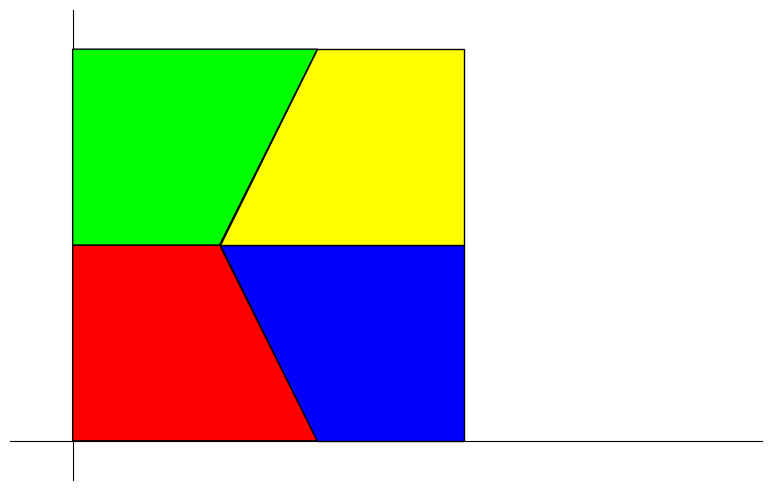

In [3]:
from compas.geometry import Polygon
from compas_plotters import Plotter

points = [[0, 0, 0], [2.5, 0, 0], [4, 0, 0],
         [0, 2, 0], [1.5, 2, 0], [4, 2, 0],
         [0, 4, 0], [2.5, 4, 0], [4, 4, 0]]
polygon_1 = Polygon([points[0], points[1], points[4], points[3]])
polygon_2 = Polygon([points[1], points[2], points[5], points[4]])
polygon_3 = Polygon([points[3], points[4], points[7], points[6]])
polygon_4 = Polygon([points[4], points[5], points[8], points[7]])

# visualize the Point
plotter = Plotter(show_axes=True)
plotter.add(polygon_1, facecolor=(1, 0, 0))
plotter.add(polygon_2, facecolor=(0, 0, 1))
plotter.add(polygon_3, facecolor=(0, 1, 0))
plotter.add(polygon_4, facecolor=(1, 1, 0))
plotter.zoom_extents()
plotter.show()

## A3. Mesh and COMPAS Mesh
A mesh is a collection of polygons arranged in a way that it can not only conserve geometric information but also topological information. There are different ways to construct a mesh.

### A3_a. `Mesh.from_polygons`
`Mesh.from_polygons` converts a series of polygons to a mesh. API reference: https://compas.dev/compas/1.5.0/api/generated/compas.datastructures.Mesh.from_polygons.html

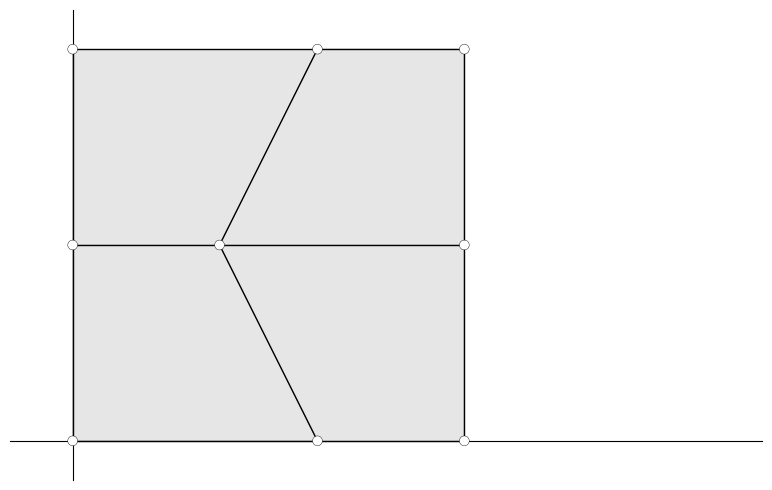

In [4]:
from compas.datastructures import Mesh
from compas.geometry import Polygon
from compas_plotters import Plotter

polygon_1 = Polygon([[0, 0, 0], [2.5, 0, 0], [1.5, 2, 0], [0, 2, 0]])
polygon_2 = Polygon([[2.5, 0, 0], [4, 0, 0], [4, 2, 0], [1.5, 2, 0]])
polygon_3 = Polygon([[0, 2, 0], [1.5, 2, 0], [2.5, 4, 0], [0, 4, 0]])
polygon_4 = Polygon([[1.5, 2, 0], [4, 2, 0], [4, 4, 0], [2.5, 4, 0]])

polygons = [polygon_1, polygon_2, polygon_3, polygon_4]

mesh = Mesh.from_polygons(polygons)

# visualize the Point
plotter = Plotter(show_axes=True)
plotter.add(mesh, sizepolicy='absolute')
plotter.zoom_extents()
plotter.show()

### A3_b. `Mesh.from_vertices_and_faces`
`Mesh.from_vertices_and_faces` construct a mesh object from a list of vertices and faces. API reference: https://compas.dev/compas/1.5.0/api/generated/compas.datastructures.Mesh.from_vertices_and_faces.html#compas.datastructures.Mesh.from_vertices_and_faces

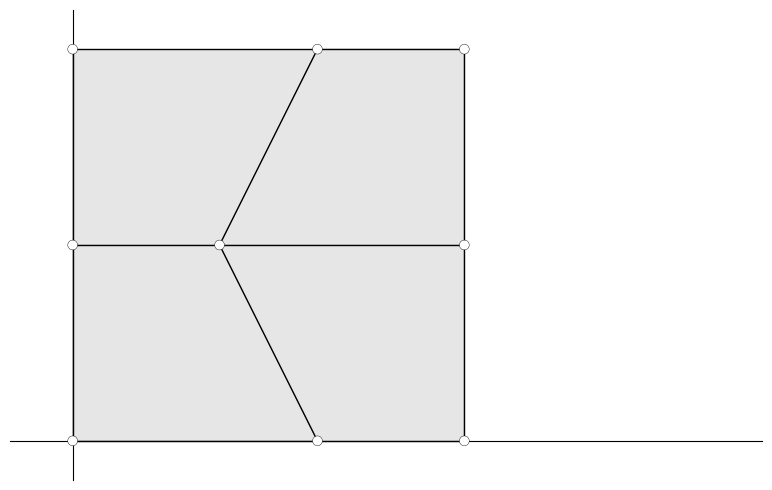

In [5]:
from compas.datastructures import Mesh
from compas_plotters import Plotter

vertices = [[0, 0, 0], [2.5, 0, 0], [4, 0, 0],
         [0, 2, 0], [1.5, 2, 0], [4, 2, 0],
         [0, 4, 0], [2.5, 4, 0], [4, 4, 0]]

faces = [[0, 1, 4, 3], [1, 2, 5, 4], [3, 4, 7, 6], [4, 5, 8, 7]]

mesh = Mesh.from_vertices_and_faces(vertices, faces)

plotter = Plotter(show_axes=True)
plotter.add(mesh, sizepolicy='absolute')
plotter.zoom_extents()
plotter.show()


## A4. Visualize Mesh in 3D Viewer
Mesh is often used to represent 3D objects. We can use the 3D viewer to visualize the mesh. The following example visualize a thrust diagram that is exported from RhinoVault2.

In [6]:
from compas.datastructures import Mesh
from compas_view2.app import App

mesh = Mesh.from_json("data/simple_dome.json")

viewer = App()
viewer.add(mesh)
viewer.run()

Let's pick up a random vertex in the mesh and move it 1 unit up along the z axis. 

In [7]:
from compas.datastructures import Mesh
from compas_view2.app import App

mesh = Mesh.from_json("data/simple_dome.json")
vkey = mesh.get_any_vertex()
xyz = mesh.vertex_coordinates(vkey)
mesh.vertex_attribute(vkey, "z", xyz[2] + 1)

viewer = App()
viewer.add(mesh)
viewer.run()

---
<a id='MeshB'></a>
# B. Mesh Vertex, Edge, Face

Mesh has three main components: **Vertex**, **edge** and **face**.

<img src="img/week5_3.png" width="1000" style="margin-left:auto; margin-right:auto"/>
</br>

A vertex is a point in 3D space, represented by the [x, y, z] coordinate. 

| Vertex Key | Coordinates |
| :---: | :---: |
| 0 | (0, 0, 0) |
| 1 | (2, 0, 0) |
| 2 | (2, 2, 0) |
| 3 | (0, 2, 0) |
| 4 | (1, 1, 2) |

An edge connects two vertices together. 

| Edge Key | (u, v) |
| :---: | :---: |
| 0 | (0, 1) |
| 1 | (1, 2) |
| 2 | (2, 3) |
| 3 | (0, 3) |
| 4 | (1, 4) |
| 5 | (2, 4) |
| 6 | (3, 4) |
| 7 | (0, 4) |

A face is constructed by connecting the edges together. A 3D geometry can be constructed by connecting faces together. 

| Face Key | Face Vertices |
| :---: | :---: |
| 0 | (0, 1, 4) |
| 1 | (1, 2, 4) |
| 2 | (2, 3, 4) |
| 3 | (0, 3, 4) |


## B1. Access Mesh Vertices, Faces and Edges
`mesh.vertices()`, `mesh.edges(`), `mesh.faces()` access the vertices, edges and faces of the mesh data structure. Note that these methods return generator objects that have to be consumed by iteration.

In [13]:
# generator objects
vertices = [[0, 0, 0], [2, 0, 0], [2, 2, 0],
         [0, 2, 0], [1, 1, 2]]

faces = [[0, 1, 4], [1, 2, 4], [2, 3, 4], [0, 3, 4]]

mesh = Mesh.from_vertices_and_faces(vertices, faces)

print(mesh.vertices())
print(mesh.edges())
print(mesh.faces())

<generator object HalfEdge.vertices at 0x18362a270>
<generator object HalfEdge.edges at 0x18362a270>
<generator object HalfEdge.faces at 0x18362a270>


In [18]:
print("Vertices")
for vertex in mesh.vertices():
     print(vertex, end=" ")

print("\nEdges")
for edge in mesh.edges():
     print(edge, end=" ")
        
print("\nFaces")
for face in mesh.faces():
     print(face, end=" ")        

Vertices
0 1 2 3 4 
Edges
(0, 1) (0, 4) (0, 3) (1, 4) (1, 2) (2, 4) (2, 3) (3, 4) 
Faces
0 1 2 3 

In [19]:
vertices = list(mesh.vertices())
print(vertices)

edges = list(mesh.edges())
print(edges)

faces = list(mesh.faces())
print(faces)

[0, 1, 2, 3, 4]
[(0, 1), (0, 4), (0, 3), (1, 4), (1, 2), (2, 4), (2, 3), (3, 4)]
[0, 1, 2, 3]


## B2. Visualize the Points

In [24]:
from compas.datastructures import Mesh
from compas.geometry import Sphere, Point
from compas_view2.app import App
from compas_view2.shapes import Text
# from compas_notebook.app import App

mesh = Mesh.from_json("data/simple_dome.json")

viewer = App()

for vkey in mesh.vertices():
    xyz = mesh.vertex_coordinates(vkey)
#     viewer.add(Sphere(xyz, 0.05), color=(0.7, 0., 0.7))
    viewer.add(Point(*xyz), color=(0.7, 0., 0.7))

# # only visualize Vertex 4
# vkey = 4
# xyz = mesh.vertex_coordinates(vkey)
# viewer.add(Point(*xyz), color=(0.7, 0., 0.7))

viewer.add(mesh)
viewer.run()

## B3. Visualize the Lines


In [21]:
from compas.datastructures import Mesh
from compas.geometry import Line
from compas_view2.app import App
# from compas_notebook.app import App

mesh = Mesh.from_json("data/simple_dome.json")

viewer = App()

for edge in mesh.edges():
    a, b = mesh.edge_coordinates(*edge)
    line = Line(a, b)
    viewer.add(line, linewidth=10, linecolor=(0, 1, 0))

viewer.add(mesh)
viewer.show()

## B4. Visualize the Faces

In [22]:
from compas.datastructures import Mesh
from compas.geometry import Polygon
from compas_view2.app import App
# from compas_notebook.app import App

mesh = Mesh.from_json("data/simple_dome.json")

viewer = App()

for fkey in mesh.faces():
    points = mesh.face_coordinates(fkey)
    polygon = Polygon(points)
    viewer.add(polygon, facecolor=(0, 0, 0.7))

viewer.add(mesh)
viewer.show()

---
<a id='MeshC'></a>
# C. Mesh Normals
There are two kinds of normals that. Face normals are orthongal vectors to the faces of the mesh. Whereas vertex normals are orthongal to the vertices.

<img src="img/week5_4.png" width="800" style="margin-left:auto; margin-right:auto"/>
</br>

## C1. Face Normals
The face normal is a vector that describes the direction that the face polygon is facing. The winding of the vertices determines the direction of the face normal.

In [23]:
from compas.datastructures import Mesh
from compas.geometry import Polygon, add_vectors, scale_vector
from compas_view2.app import App
# from compas_notebook.app import App

mesh = Mesh.from_json("data/simple_dome.json")

viewer = App()

scale_factor = 0.5 
for fkey in mesh.faces():
    f_normal = mesh.face_normal(fkey)
    f_centorid = mesh.face_centroid(fkey)
    line = Line(f_centorid, add_vectors(f_centorid, scale_vector(f_normal, scale_factor)))
    viewer.add(line, linecolor=(1, 0, 0))

viewer.add(mesh)
viewer.show()

## C2. Vertex Normals
The vertex normal is the weighted average of the normals of the neighboring faces.

In [25]:
from compas.datastructures import Mesh
from compas.geometry import Polygon, add_vectors, scale_vector
from compas_view2.app import App
# from compas_notebook.app import App

mesh = Mesh.from_json("data/simple_dome.json")

viewer = App()

scale_factor = 0.5 
for vkey in mesh.vertices():
    v_normal = mesh.vertex_normal(vkey)
    xyz = mesh.vertex_coordinates(vkey)
    line = Line(xyz, add_vectors(xyz, scale_vector(v_normal, scale_factor)))
    viewer.add(line, linecolor=(1, 0, 0))

viewer.add(mesh)
viewer.show( d

---

<a id='MeshD'></a>
# D. Exercise: Geodesic Dome
In the following example, we will try to materialize a geodesic dome. We will use spheres/cylinders, cylinders, polygons to represent joints, bars and facades.  

<img src="https://i.pinimg.com/originals/0e/ce/2f/0ece2f10e2f7ef68e8603fc07d786bd6.jpg" width="400" style="margin-left:auto; margin-right:auto"/>
</br>

## D1. Load Mesh

In [26]:
from compas.datastructures import Mesh
from compas.geometry import Polygon, add_vectors, scale_vector
from compas_view2.app import App
# from compas_notebook.app import App

mesh = Mesh.from_json("data/geodome.json")

viewer = App()
viewer.add(mesh)
viewer.show()

## D2. Draw Joints

In [10]:
from compas.geometry import Sphere

viewer = App()

for vkey in mesh.vertices():
    viewer.add(Sphere(mesh.vertex_coordinates(vkey), 0.1), color=(1, 0, 0))

# viewer.add(mesh)
viewer.run()

In [12]:
from compas.geometry import Cylinder, Plane, Circle

viewer = App()

for vkey in mesh.vertices():
    xyz = mesh.vertex_coordinates(vkey)
    normal = mesh.vertex_normal(vkey)
    
    plane = Plane(xyz, normal) # center, normal
    circle = Circle(plane, 0.1)
    
    cylinder = Cylinder(circle, 0.1)
    viewer.add(cylinder, color=(1, 0, 0))

# viewer.add(mesh)
viewer.run()

## D3. Draw Bars

In [13]:
from compas.geometry import Plane, Vector, Circle, Cylinder
from compas_view2.app import App

viewer = App()
# viewer.add(mesh)

for vkey in mesh.vertices():
    xyz = mesh.vertex_coordinates(vkey)
    normal = mesh.vertex_normal(vkey)
    
    plane = Plane(xyz, normal) # center, normal
    circle = Circle(plane, 0.1)
    
    cylinder = Cylinder(circle, 0.1)
    viewer.add(cylinder, color=(1, 0, 0))
    
    
for (u, v) in mesh.edges():
    u_xyz = mesh.vertex_coordinates(u)
    v_xyz = mesh.vertex_coordinates(v)

# pipe:   circle ([plane, radius] | Circle) – The circle of the cylinder.
#         height (float) – The height of the cylinder.
    center = [0.5 * (a + b) for a, b in zip(u_xyz, v_xyz)]
    normal = Vector.from_start_end(v_xyz, u_xyz)
    plane = Plane(center, normal) # center, normal
    circle = Circle(plane, 0.03)
    
    cylinder = Cylinder(circle, normal.length - 0.1)
    viewer.add(cylinder)

viewer.run()

## D4. Draw Facades

In [14]:
from compas.geometry import Polygon, Translation, scale_vector
from compas_view2.app import App

viewer = App()

for vkey in mesh.vertices():
    xyz = mesh.vertex_coordinates(vkey)
    normal = mesh.vertex_normal(vkey)
    
    plane = Plane(xyz, normal) # center, normal
    circle = Circle(plane, 0.1)
    
    cylinder = Cylinder(circle, 0.1)
    viewer.add(cylinder, color=(1, 0, 0))
    
    
for (u, v) in mesh.edges():
    u_xyz = mesh.vertex_coordinates(u)
    v_xyz = mesh.vertex_coordinates(v)

# pipe:   circle ([plane, radius] | Circle) – The circle of the cylinder.
#         height (float) – The height of the cylinder.
    center = [0.5 * (a + b) for a, b in zip(u_xyz, v_xyz)]
    normal = Vector.from_start_end(v_xyz, u_xyz)
    plane = Plane(center, normal) # center, normal
    circle = Circle(plane, 0.03)
    
    cylinder = Cylinder(circle, normal.length - 0.1)
    viewer.add(cylinder)
    
dis = 0.05
for fkey in mesh.faces():
    points = mesh.face_coordinates(fkey)
    polygon = Polygon(points)
    
    f_normal = mesh.face_normal(fkey)
    T = Translation.from_vector(scale_vector(f_normal, dis))
    polygon.transform(T)
    
    viewer.add(polygon, facecolor=(0, 0, 0.7))
        
viewer.run()

In [15]:
from compas.geometry import Polygon, Translation, scale_vector, Scale, Frame
from compas_view2.app import App

viewer = App()

for vkey in mesh.vertices():
    xyz = mesh.vertex_coordinates(vkey)
    normal = mesh.vertex_normal(vkey)
    
    plane = Plane(xyz, normal) # center, normal
    circle = Circle(plane, 0.1)
    
    cylinder = Cylinder(circle, 0.1)
    viewer.add(cylinder, color=(1, 0, 0))
    
    
for (u, v) in mesh.edges():
    u_xyz = mesh.vertex_coordinates(u)
    v_xyz = mesh.vertex_coordinates(v)

# pipe:   circle ([plane, radius] | Circle) – The circle of the cylinder.
#         height (float) – The height of the cylinder.
    center = [0.5 * (a + b) for a, b in zip(u_xyz, v_xyz)]
    normal = Vector.from_start_end(v_xyz, u_xyz)
    plane = Plane(center, normal) # center, normal
    circle = Circle(plane, 0.03)
    
    cylinder = Cylinder(circle, normal.length - 0.1)
    viewer.add(cylinder)
    
dis = 0.05
for fkey in mesh.faces():
    points = mesh.face_coordinates(fkey)
    polygon = Polygon(points)
    
    f_normal = mesh.face_normal(fkey)
    T = Translation.from_vector(scale_vector(f_normal, dis))
    polygon.transform(T)
    
    f_centroid = mesh.face_centroid(fkey)
    plane = Plane(f_centroid, f_normal)
    frame = Frame.from_plane(plane)
    S = Scale.from_factors([0.93] * 3, frame)
    polygon.transform(S)
    
    viewer.add(polygon, facecolor=(0, 0, 0.7))
        
viewer.run()